 >GoogLeNet 名字中的 **L** 是大写，为了致敬 LeNet..

![image.png](<https://i.typlog.com/tanxy/8334438016_224058.png>)
![image.png](<https://i.typlog.com/tanxy/8334437851_627911.png>)
![image.png](<https://i.typlog.com/tanxy/8334437745_131577.png>)
![image.png](<https://i.typlog.com/tanxy/8334437631_240162.png>)
![image.png](<https://i.typlog.com/tanxy/8334437529_948467.png>)
![image.png](<https://i.typlog.com/tanxy/8334437247_971501.png>)
![image.png](<https://i.typlog.com/tanxy/8334437096_280459.png>)
![image.png](<https://i.typlog.com/tanxy/8334436984_563748.png>)
![image.png](<https://i.typlog.com/tanxy/8334436930_817663.png>)

## 总结
+ Inception 块用 4 条有不同超参数的卷积层和池化层的路来抽取不同的消息
    + 他的主要一个优点是模型参数小，计算复杂度低
+ GoogleNet 使用了 9 个 Inception 块，是第一个达到上百层的网络
    + 后续有一系列改进

---

In [33]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Inception(nn.Module):
    # c1--c4是每条路径的输出通道数
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # 线路1，单1x1卷积层
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 线路2，1x1卷积层后接3x3卷积层
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 线路3，1x1卷积层后接5x5卷积层
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，3x3最大汇聚层后接1x1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # 在通道维度上连结输出
        return torch.cat((p1, p2, p3, p4), dim=1)

接下来就是利用上面的定义的 Inception 块去实现每一个 **stage**，每一个 stage 用一个 sequential module

![image.png](<https://i.typlog.com/tanxy/8334435565_243508.png>)


In [34]:
# stage1
# 第一个 stage 使用 64 个通道输出、7×7 卷积层
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
# stage2
# 第二个 stage 使用两个卷积层，第一个卷积层是 64 个通道、1×1的卷积层；
# 第⼆个卷积层使⽤将通道数量增加三倍的3 × 3卷积层。这对应于Inception块中的第⼆条路径。
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# stage3
# 第三个模块串联两个完整的 Inception 块，第一个 Inception 块最终四条路线输出通道数为 64 + 128 + 32 + 32 = 256
# 即四条路径之间的输出通道数之比为 2:4:1:1，第二个和第三个路径首先将输入通道数的数量分别减少到 96/192=1/2 和 16/192=1/12，然后连接第二个卷积层
# 第二个 Inception 块的输出通道数增加到 128 + 192 +96 +64 = 480，四个路径之间的输出通道数之比为 4:6:3:2
# 第二条和第三条路径首先将输入通道的数量分别减少到 128/256=1/2 和 32/256=1/8
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

第四模块更加复杂，它串联了5个Inception块，其输出通道数分别是192 + 208 + 48 + 64 = 512、160 + 224 + 64 + 64 = 512、128 + 256 + 64 + 64 = 512、112 + 288 + 64 + 64 = 528和256 + 320 + 128 + 128 = 832。这些路径的通道数分配和第三模块中的类似，⾸先是含3×3卷积层的第⼆条路径输出最多通道，其次是仅含1×1卷积层的第⼀条路径，之后是含5×5卷积层的第三条路径和含3×3最⼤汇聚层的第四条路径。其中第⼆、第三条路径都会先按⽐例减⼩通道数。这些⽐例在各个Inception块中都略有不同。


In [35]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

第五模块包含输出通道数为256 + 320 + 128 + 128 = 832和384 + 384 + 128 + 128 = 1024的两个Inception块。其中每条路径通道数的分配思路和第三、第四模块中的⼀致，只是在具体数值上有所不同。需要注意的是，第五模块的后⾯紧跟输出层，该模块同NiN⼀样使⽤全局平均汇聚层，将每个通道的⾼和宽变成1。最后我们将输出变成⼆维数组，再接上⼀个输出个数为标签类别数的全连接层。

In [36]:
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [37]:
# 实例化网络
net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))
print(net)

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Inception(
      (p1_1): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (p2_1): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (p2_2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (p3_1): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (p3_2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (p4_1): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (p4_2): Conv2d(192, 32, ker

In [38]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


training on cuda:0


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 433.82 MiB already allocated; 8.50 MiB free; 438.00 MiB reserved in total by PyTorch)

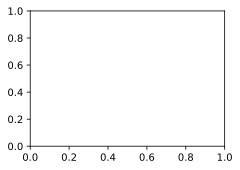

In [39]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())